# Generate isometric EMG contractions

## Imports

In [61]:
# Imports
# -------
import numpy as np
import scipy
import torch
import os, sys, h5py
from copy import copy

import matplotlib.pyplot as plt
import seaborn as sns

%load_ext autoreload
%autoreload 2

from easydict import EasyDict as edict
from NeuroMotion.MNPoollib.MNPool import MotoneuronPool
from NeuroMotion.MNPoollib.mn_params import mn_default_settings
from NeuroMotion.MNPoollib.mn_utils import ensure_spikes_in_range, plot_spike_trains, spikes_to_bin, generate_emg
from NeuroMotion.loaders import load_gen_data, load_sim_emg, save_sim_emg
from motor_unit_toolbox import muap_comp

sns.set(font_scale=1.1, style="whitegrid")

# Functions
# ---------
def compute_rms(emg, timestamps, win_len_s, win_step_s, fs=2048):

    # Initialise variables
    win_len = np.round( win_len_s * fs ).astype(int)
    win_step = np.round( win_step_s * fs ).astype(int)

    samples, chs = emg.shape
    win_num = np.round( (samples - win_len)/win_step ).astype(int) +1 

    timestamps_aux = np.linspace( timestamps[0], timestamps[-1], win_num)
    rms_aux = np.zeros((win_num, chs))

    # Compute RMS
    for win in range(win_num):
        mask = np.arange( 0 + win_step * win, np.amin( [win_len + win_step * win, samples] ) ).astype(int)
        rms_aux[win] = np.sqrt( np.mean( emg[mask]**2, axis=0) )
    
    # Interpolate RMS to match EMG signals
    rms = np.zeros_like(emg)
    for ch in range(chs):
        rms[:, ch] = scipy.interpolate.Akima1DInterpolator( timestamps_aux, rms_aux[:, ch] )( timestamps ) 

    return rms

def plot_ch(data, timestamps, delta = 5, ax = None, palette_name = "viridis", **kwarg):
    """Plot data per channel in a single plot

    Args:
        data : ndarray with shape (samples, channels)
            Data to be displayed
        timestamps : ndarray with shape (samples,)
            Data timestamps
        delta : int (optional, dafault = 5)
            Gain applied to the maximum of the data to modulate space between channels
        ax : matplotlib axes (optional, default = None)
            Axes to plot the data
        palette_name : Str (optional, default = "viridis")
            Name of the seaborn palette used for plotting

    Returns:
        ax : matplotlib axes
            Axes where the data is plotted
    """

    # Data size
    samples, chs = data.shape

    # Compute channel offset
    max_val = np.nanmax(data)
    offset = max_val/delta

    # Apply offset to signals
    data_plot = copy(data)
    data_plot += range(0,chs) * offset

    # Plot signals
    if ax is None:
        fig, ax = plt.subplots()
    
    # Create color palette and assign it to the axis cycle
    color_palette = sns.color_palette(palette_name, chs).as_hex()
    ax.set_prop_cycle(color=color_palette)
    
    ax.plot(timestamps, data_plot, **kwarg)
    ax.margins(0) # padding for each limit of the axis
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Channels')
    ax.grid(True, axis='x')
    ch_ticks = np.linspace(0, (chs -1) * offset, chs)
    sel_chs = np.arange(0, chs, 5)
    ax.set_yticks(ch_ticks[sel_chs], sel_chs)

    return ax

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Muscle and contraction parameters

In [7]:
# Movement properties
muscle = 'FDSI'
sampling = 'default'
mov_type = 'flx_ext'
excitation_level = 30
duration_s = 30
fs = 2048
num_mus = 100
sel_angle = 0

angles = {
    'flex': -65,
    'default': 0,
    'ext': 65,
}
morphs, ch_rows, ch_cols, samples = 130, 10, 32, 96
muap_angle_labels = np.linspace(angles['flex'], angles['ext'], morphs ).astype(int)

In [16]:
# Load data
# ---------
bs = 0
data_path = os.path.join(
    os.environ['HOME'], 
    'NeuroMotion', 'res',
    f'{muscle}_{mov_type}_{num_mus}mu_bs{bs}',
    f'sim_muaps_{sampling}_{muscle}_{num_mus}_{mov_type}_sample.hdf5'
)
sim = load_gen_data(data_path)
print(f"{muscle}: {sim['muaps'].shape}")

FDSI: (100, 130, 10, 32, 96)


In [18]:
# Generate MUAP angle labels
# --------------------------
muap_angle_labels = np.linspace(angles['flex'], angles['ext'], sim['muaps'].shape[1]).astype(int)
units, morphs, ch_rows, ch_cols, win = sim['muaps'].shape
chs =  ch_rows * ch_cols
idx_sel_angle = np.nonzero(muap_angle_labels == sel_angle)[0][0]

In [19]:
# Get MUAPs at 0 deg
# ------------------
muaps_at_angle = sim['muaps'][:,idx_sel_angle]
print(muaps_at_angle.shape)

(100, 10, 32, 96)


In [21]:
# Compute distances
# -----------------
muaps_dist, muaps_lags = muap_comp.compute_all_muaps_dist(muaps_at_angle, dist_metric="nmse", sel_chs_method="iqr")

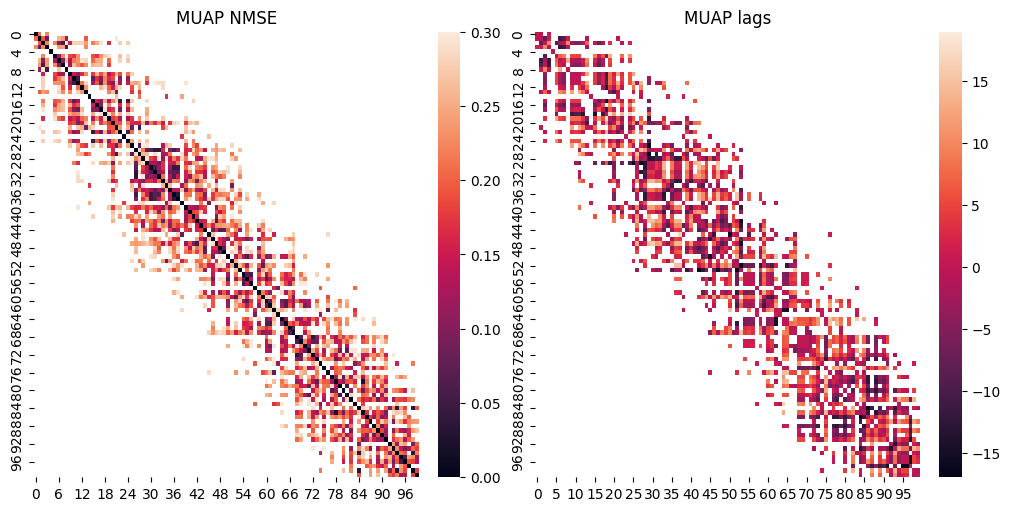

In [22]:
# Plot similarity
# ---------------
fig, axs = plt.subplots(1,2,figsize=(10,5), layout='constrained')
sns.heatmap(muaps_dist, annot=False, vmin=0, vmax=0.3, mask=muaps_dist>0.3, cmap="rocket", ax=axs[0])
axs[0].set(title='MUAP NMSE')
sns.heatmap(muaps_lags, annot=False, ax=axs[1], mask=muaps_dist>0.3, cmap="rocket")
axs[1].set(title='MUAP lags')
plt.show()

In [23]:
# Clusterise MUAPs based on the NMSE
# ----------------------------------
opt_thr_info, cluster_out = muap_comp.cluster_muaps(muaps_dist, cluster_method="ward", dist_metric="nmse", sel_chs_method="iqr", thr_vals=[0.2], flag_plot=False)

# Get unique MUAPs
cluster_labels, cluster_idxs = np.unique(cluster_out['labels'], return_index=True)
print(f'Number of unique clusters: {len(cluster_labels)}')
print(f'Indexes: {cluster_idxs}')

Number of unique clusters: 38
Indexes: [84 95 87 97 57 74 70 68 73 75 77  1  0  2  5  4  9 15 16 13 12 18 62 66
 52 60 46 38 34 14 23 44 53 30 26 41 28 35]


/rds/general/user/im4417/home/NeuroMotion/motor_unit_toolbox/motor_unit_toolbox/muap_comp.py:611: RuntimeWarning: Mean of empty slice
  np.nanmean(all_muaps_dist[np.ix_(curr_cluster_mask, curr_cluster_mask)])
/rds/general/user/im4417/home/anaconda3/envs/NeuroMotion/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1671: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


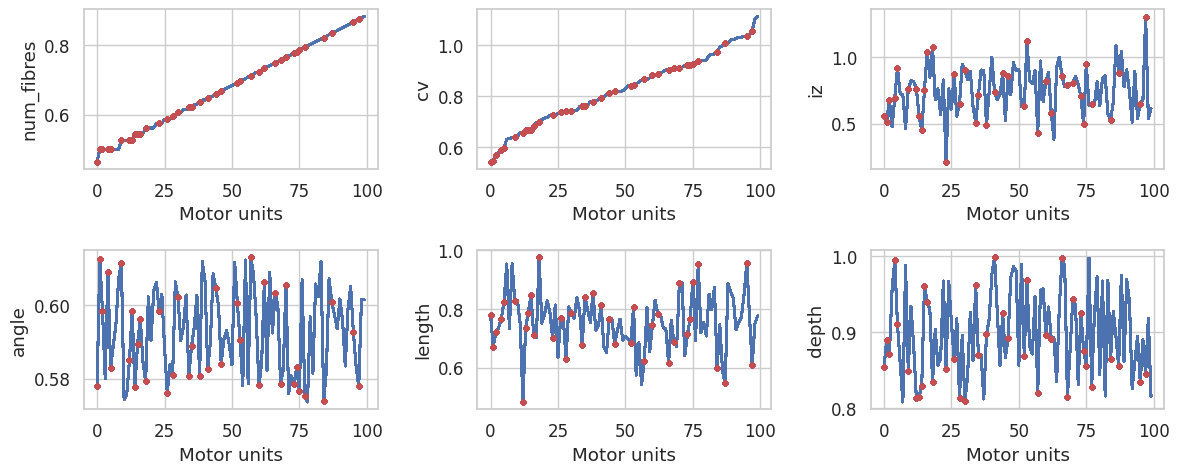

In [62]:
# Plot properties of selected ones
# -------------------------------
fig, axs = plt.subplots(2,3,figsize=(12,5))
axs = np.ravel(axs)

for i, key in enumerate(['num_fibres', 'cv', 'iz', 'angle', 'length', 'depth']):
    axs[i].plot(sim['neural_params'][key], 'b')
    axs[i].plot(cluster_idxs, sim['neural_params'][key][cluster_idxs], 'r.')
    axs[i].set_ylabel(key)
    axs[i].set_xlabel('Motor units')

# axs[2].legend(bbox_to_anchor=(1.1,1))

plt.tight_layout()
plt.show()

## Save selected MUAPs

In [ ]:
# Generate MUAP angle labels
# --------------------------
# sel_muaps = sim['muaps'][np.sort(cluster_idxs)]
# units, morphs, ch_rows, ch_cols, win = sel_muaps.shape
# chs =  ch_rows * ch_cols
# samples = duration_s * fs
# print(units, morphs, ch_rows, ch_cols, win, samples)

# sel_muaps_props = {
#     'num': sim['neural_params']['num_fibres'][np.sort(cluster_idxs)],
#     'depth': sim['neural_params']['depth'][np.sort(cluster_idxs)],
#     'angle': sim['neural_params']['angle'][np.sort(cluster_idxs)],
#     'iz': sim['neural_params']['iz'][np.sort(cluster_idxs)],
#     'len': sim['neural_params']['length'][np.sort(cluster_idxs)],
#     'cv': sim['neural_params']['cv'][np.sort(cluster_idxs)],
# }

35 130 10 32 96 61440


In [ ]:
# Save selected units
# save_unique_path = os.path.join(
#     os.environ['HOME'], 
#     'NeuroMotion', 'res',
#     f'{muscle}_{mov_type}_{num_mus}mu_bs{bs}',
#     f'sim_muaps_{sampling}_{muscle}_{num_mus}_{mov_type}_sample_unique.hdf5'
# )

# with h5py.File( save_unique_path, 'w') as h5:

#     # MUAPs
#     h5.create_dataset('sim_muaps', data = sel_muaps)
#     h5.create_dataset('fs', data = fs)
#     h5.create_dataset('cluster_idxs', data = np.sort(cluster_idxs))
#     h5.create_dataset('iz', data = sel_muaps_props['iz'])
#     h5.create_dataset('cv', data = sel_muaps_props['cv'])
#     h5.create_dataset('num', data = sel_muaps_props['num'])
#     h5.create_dataset('angle', data = sel_muaps_props['angle'])
#     h5.create_dataset('len', data = sel_muaps_props['len'])
#     h5.create_dataset('depth', data = sel_muaps_props['depth'])
# print('Data saved!')

Data saved!


## Generate angles and force activations per muscle depending on the angle (movement)

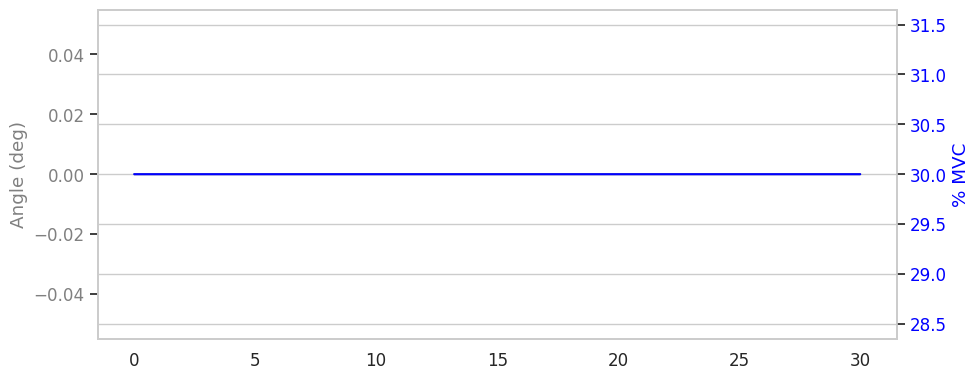

In [63]:
muscle_force = np.ones(duration_s * fs) * excitation_level
angle_profile = np.ones(duration_s * fs) * sel_angle
timestamps = np.linspace(0, duration_s, duration_s * fs)

# Plot mucle force and angle
fig, ax1 = plt.subplots(1,1,figsize=(10,4))

color = 'grey'
ax1.set_ylabel('Angle (deg)', color=color)
ax1.plot(timestamps, angle_profile, color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(False)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color='blue'
ax2.set_ylabel('% MVC', color=color)  # we already handled the x-label with ax1
ax2.plot(timestamps, muscle_force, color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_xlabel('Time (s)', color=color)

plt.tight_layout()
plt.show()

## Generate spike trains per muscle

FDSI - number of active mu:  77


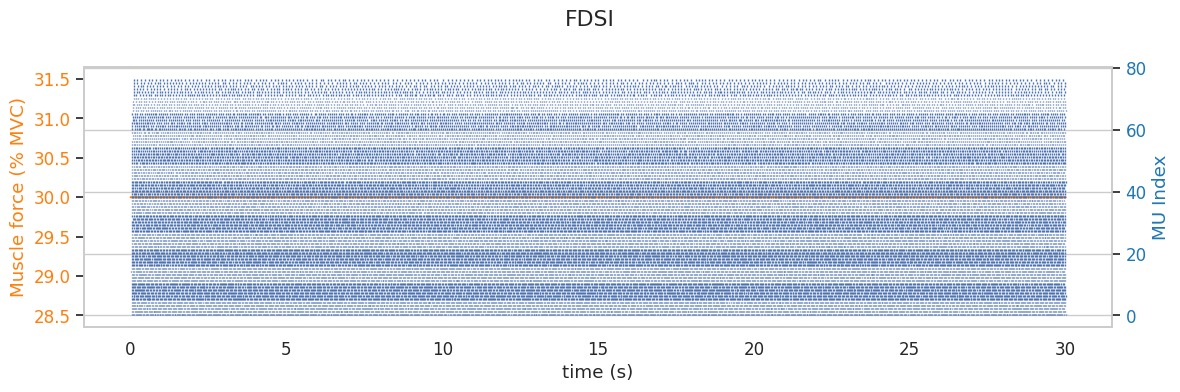

In [64]:
# Initialise motor neuron pool and assign properties (common across all muscles)
mn_pool = MotoneuronPool(num_mus, muscle, **mn_default_settings)

# Initialise properties with those of the selected units
mn_pool.properties = sim['neural_params']
muscle_properties = sim['neural_params']

# Generate spike trains based on force activations
mn_pool.init_twitches(fs)
mn_pool.init_quisistatic_ef_model()
ext_new, spikes, fr, ipis = mn_pool.generate_spike_trains(muscle_force/100, fit=False)
# spikes, fr = mn_pool.generate_spike_trains( muscle_force/100, fs)
spikes = ensure_spikes_in_range(spikes,len(timestamps))

# Check number of active units
active_mu = 0
for sp in spikes:
    if len(sp) > 0:
        active_mu += 1
print(f'{muscle} - number of active mu: ', active_mu)

# Store them
muscle_mn = {
    'spikes': spikes,
    'fr': fr,
}

# Plot
fig, ax1 = plt.subplots(1,1,figsize=(12,4))

color = 'tab:orange'
ax1.set_xlabel('time (s)')
ax1.set_ylabel('Muscle force (% MVC)', color=color)
ax1.plot(timestamps, muscle_force, color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(False)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Motor units', color=color)  # we already handled the x-label with ax1
ax2 = plot_spike_trains(muscle_mn['spikes'], ax=ax2, fs=fs)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_xlabel('Time (s)')

plt.suptitle(muscle)
plt.tight_layout()
plt.show()

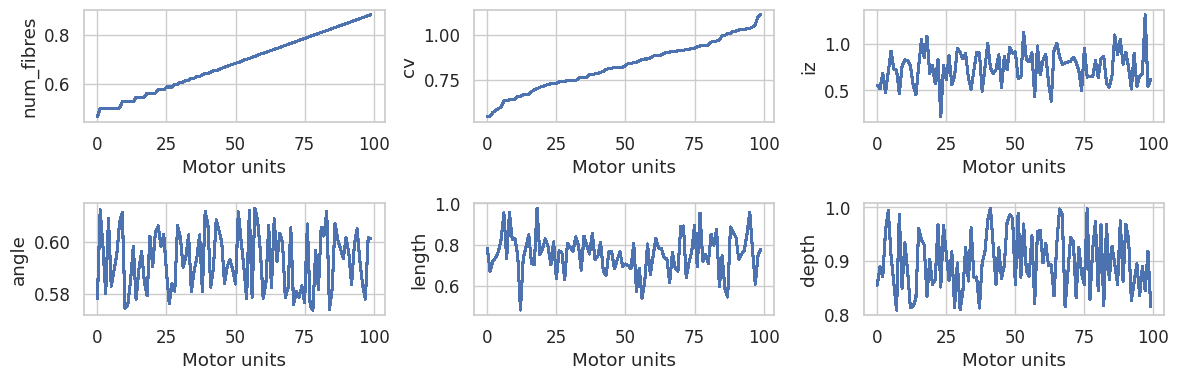

In [65]:
fig, axs = plt.subplots(2,3,figsize=(12,4))
axs = np.ravel(axs)

for i, key in enumerate(['num_fibres', 'cv', 'iz', 'angle', 'length', 'depth']):
    axs[i].plot(muscle_properties[key], 'b')
    axs[i].set_ylabel(key)
    axs[i].set_xlabel('Motor units')

plt.tight_layout()
plt.show()

In [78]:
# Format spikes
bin_spikes = spikes_to_bin(muscle_mn['spikes'], len(timestamps))
check = np.all( np.equal( np.array([len(spike) for spike in muscle_mn["spikes"]]), bin_spikes.sum(0) ))
units_active = bin_spikes.sum(0).astype(bool)
muscle_fspikes = bin_spikes[:, units_active]
print(f'{muscle}: {check}, {bin_spikes.shape}')

FDSI: True, (61440, 100)


In [67]:
spike_count = []
for spike in spikes:
    spike_count.append(len(spike))
print(spike_count)

[760, 756, 758, 749, 742, 753, 753, 751, 751, 739, 731, 735, 730, 739, 727, 725, 725, 726, 725, 716, 715, 718, 713, 710, 714, 706, 705, 693, 693, 685, 684, 681, 678, 681, 666, 665, 653, 655, 649, 645, 637, 627, 631, 627, 620, 609, 602, 601, 586, 585, 574, 567, 557, 552, 546, 528, 519, 507, 506, 496, 480, 463, 455, 443, 432, 418, 403, 392, 376, 365, 345, 329, 314, 300, 284, 263, 245, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [55]:
ch_map = np.arange(320).astype(int).reshape(10,32)
print(ch_map)
# print(ch_map[np.ix_(range(0,8),range(2,10))])
# print(ch_map.reshape(320))

[[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
   18  19  20  21  22  23  24  25  26  27  28  29  30  31]
 [ 32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49
   50  51  52  53  54  55  56  57  58  59  60  61  62  63]
 [ 64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80  81
   82  83  84  85  86  87  88  89  90  91  92  93  94  95]
 [ 96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113
  114 115 116 117 118 119 120 121 122 123 124 125 126 127]
 [128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145
  146 147 148 149 150 151 152 153 154 155 156 157 158 159]
 [160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177
  178 179 180 181 182 183 184 185 186 187 188 189 190 191]
 [192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209
  210 211 212 213 214 215 216 217 218 219 220 221 222 223]
 [224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240

## Generate EMG per muscle

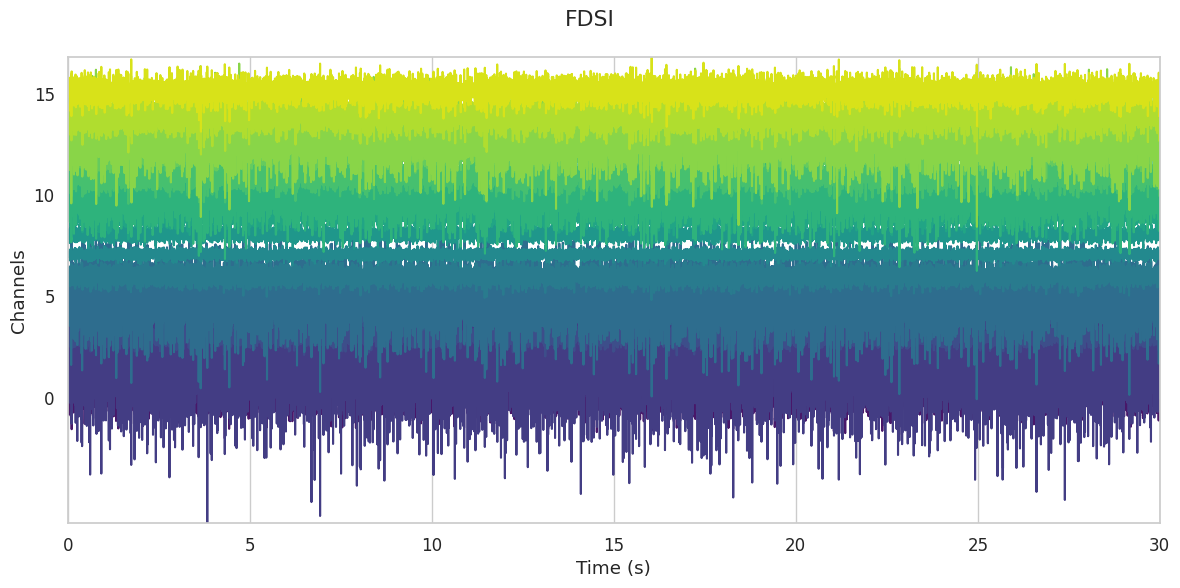

In [79]:
# Generate EMG
# ------------
muscle_emg = generate_emg(sim['muaps'], muscle_mn['spikes'], muap_angle_labels, angle_profile)
samples = len(timestamps)
fig, axs = plt.subplots(1,1,figsize=(12,6))
axs = plot_ch( muscle_emg.reshape(chs, samples).T[:, 0:chs:20], timestamps, ax=axs)
plt.suptitle(muscle)
plt.tight_layout()
plt.show()

## Combine all muscle contributions

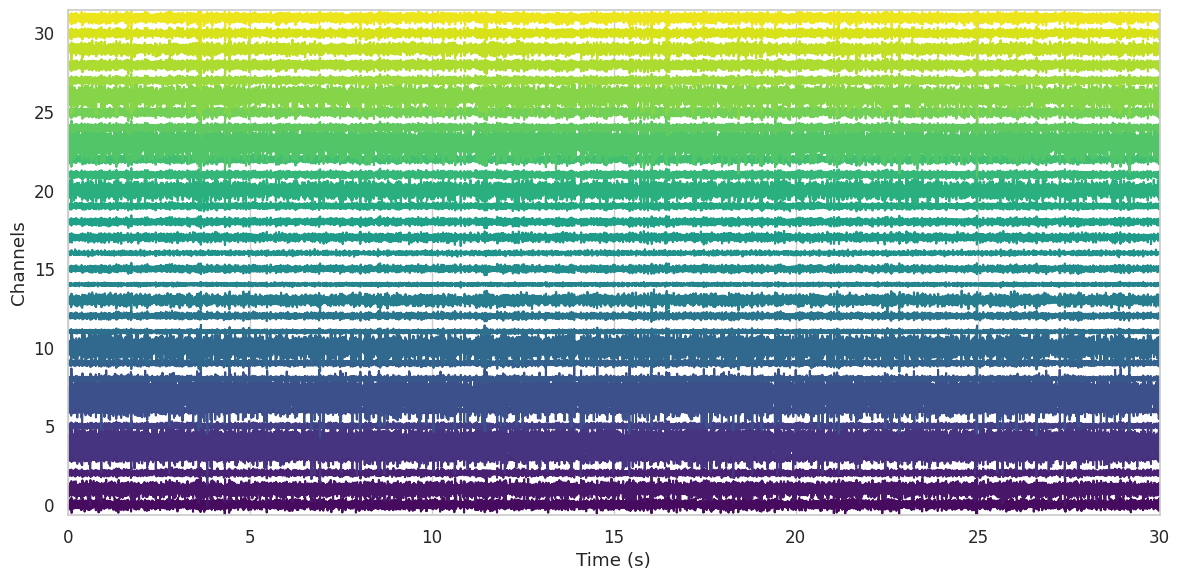

In [80]:
# Center EMG
emg_all = muscle_emg
emg_all -= emg_all.mean(-1)[:,:,None]
emg_all = emg_all.reshape(chs, samples).T

# Plot EMG
fig, axs = plt.subplots(1,1,figsize=(12,6))
axs = plot_ch(emg_all[:,0:chs:10], timestamps, ax=axs, delta=2)
plt.tight_layout()
plt.show()

In [81]:
# Concatenate all the spikess
spikes = bin_spikes
spikes_muscles = bin_spikes.shape[-1]

print(spikes.shape)
print(np.array(spikes_muscles))

(61440, 100)
100


In [89]:
spikes_muscles

100

In [82]:
spikes.sum(0)

array([760, 756, 758, 749, 742, 753, 753, 751, 751, 739, 731, 735, 730,
       739, 727, 725, 725, 726, 725, 716, 715, 718, 713, 710, 714, 706,
       705, 693, 693, 685, 684, 681, 678, 681, 666, 665, 653, 655, 649,
       645, 637, 627, 631, 627, 620, 609, 602, 601, 586, 585, 574, 567,
       557, 552, 546, 528, 519, 507, 506, 496, 480, 463, 455, 443, 432,
       418, 403, 392, 376, 365, 345, 329, 314, 300, 284, 263, 245,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0])

30 dB - mean noise: 2.0931475124222073e-06


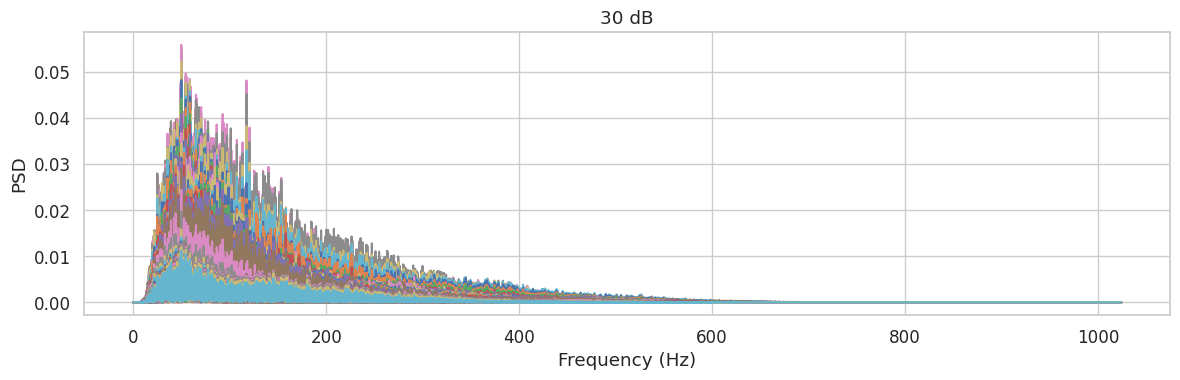

In [86]:
# Generate noise
snr_level = 30
np.random.seed(0)

# Initialise variables
std_emg = emg_all.std()
std_noise = std_emg * 10 ** (-snr_level/20)

fig, axs = plt.subplots(1,1,figsize=(12,4), sharex=True, sharey=False)

# Scipy recommends second-order sections (sos) filtering to avoid numerical problems
sos = scipy.signal.butter(2, [20, 500], 'bandpass', fs=fs, output='sos')

# Generate noise
noise = np.random.normal(loc=0, scale=1, size=emg_all.shape) * std_noise

print(f'{snr_level} dB - mean noise: {noise.mean()}')

# Apply noise
emg = copy(emg_all) + noise

# Preprocess EMG
emg_filt = scipy.signal.sosfiltfilt(sos, emg, axis=0)  
emg_filt -= emg_filt.mean(0)[None,:]

# Compute RMS
rms_emg_filt = compute_rms(emg_filt, timestamps, 0.1, 0.1, fs)

# Save data
dir_save = os.path.join(
    os.environ['HOME'], 
    'NeuroMotion', 'res',
    f'{muscle}_{mov_type}_{num_mus}mu_bs{bs}'
)
file_save = os.path.join( dir_save, f'semg_{muscle}_static_prepro_{snr_level}dB.hdf5')

os.makedirs(dir_save, exist_ok=True)

data = {
    'emg': emg_filt,
    'spikes': spikes,
    'spikes_muscles': np.array(spikes_muscles),
    'rms': rms_emg_filt.mean(-1),
    'noise': noise,
    'fs': fs,
    'angle_profile': angle_profile,
    'force_profile': muscle_force,
    'timestamps': timestamps,
    'ch_map': ch_map,
}
save_sim_emg(file_save, data)

# Plot
yf = scipy.fft.fft(emg_filt, axis=0)
xf = scipy.fft.fftfreq(samples, 1/fs)[:samples//2]
axs.plot(xf, 2/samples * np.abs(yf[0:samples//2]))
axs.set_xlabel('Frequency (Hz)')
axs.set_ylabel('PSD')
axs.set_title(f'{snr_level} dB')

plt.tight_layout()
plt.show()

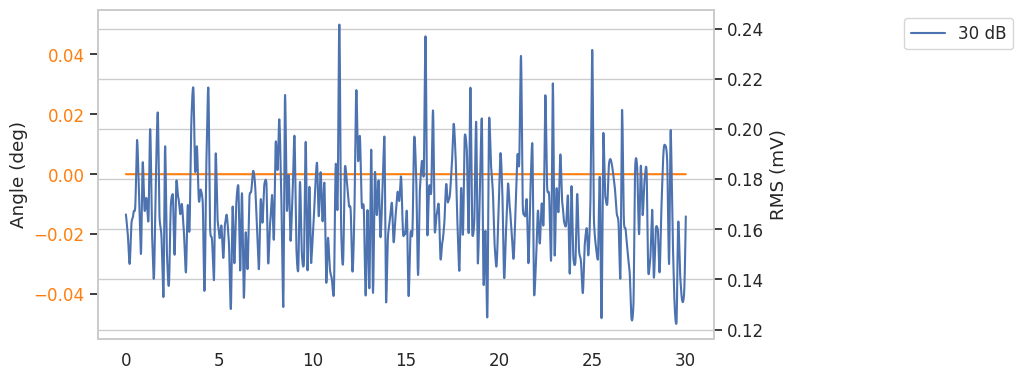

In [88]:
# Plot
fig, ax1 = plt.subplots(1,1,figsize=(12,4))

color = 'tab:orange'
ax1.set_ylabel('Angle (deg)')
ax1.plot(timestamps, angle_profile, color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(False)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('RMS (mV)')  # we already handled the x-label with ax1

# Load data
dir_load = os.path.join(
    os.environ['HOME'], 
    'NeuroMotion', 'res',
    f'{muscle}_{mov_type}_{num_mus}mu_bs{bs}'
)
file_load = os.path.join(dir_load, f'semg_{muscle}_static_prepro_{snr_level}dB.hdf5')
data = load_sim_emg(file_load)

# Plot RMS
label_plot = f'{snr_level} dB'
ax2.plot(timestamps, data['rms'], label=label_plot)
ax2.tick_params(axis='y')

ax2.legend(bbox_to_anchor=(1.5,1))
ax2.set_xlabel('Time (s)')
plt.tight_layout()
plt.show()
        

## Format data for spike sorting 

In [ ]:
import torch
save_dir = os.path.join(os.environ['EPHEMERAL'], fr'neuromotion/emg')         
    
# Prepare paths
if curr_period == 'static':
    file_path = os.path.join(os.environ['EPHEMERAL'], f'neuromotion/emg/semg_neuromotion_static/semg_neuromotion_static_prepro.hdf5')
    save_folder = os.path.join(save_dir, f'semg_neuromotion_static')
else:
    file_path = os.path.join(os.environ['EPHEMERAL'], f'neuromotion/emg/semg_neuromotion_dynamic_{curr_period}/semg_neuromotion_dynamic_{curr_period}_prepro.hdf5')
    save_folder = os.path.join(save_dir, f'semg_neuromotion_dynamic_{curr_period}')
os.makedirs(save_folder, exist_ok=True)

# Load data
data = load_emg_dataset(file_path)

# Save spikes as a list of tensors
gt_spikes = []
for unit in range(data['spikes'].shape[1]):
    firings = np.nonzero(data['spikes'][:, unit])[0]
    gt_spikes.append(torch.from_numpy(firings))
save_firings_file = os.path.join(save_folder,f'semg_neuromotion_dynamic_{curr_period}_gt_firings.pt')
torch.save(gt_spikes, save_firings_file)

# Save EMG (flexors only) as .npy
sel_chs = np.reshape(data['ch_map'][np.ix_(range(0,8),range(2,10))], [-1])
emg_flx = data['emg'][:,sel_chs]
save_emg_file = os.path.join(save_folder,f'semg_neuromotion_dynamic_{curr_period}.npy')
np.save(save_emg_file, emg_flx)

# Save motion ground truth as .npy
save_dyn_file = os.path.join(save_folder,f'semg_neuromotion_dynamic_{curr_period}_gt_dynamics.npy')
np.save(save_dyn_file, data['angle_profile'])

print('Formatted data saved!')

Formatted data saved!
